# Análisis de Serie Temporal - Consumo de Diésel

Este notebook documenta el análisis de la serie temporal del consumo de diésel, cubriendo las etapas requeridas en el laboratorio:

- Análisis exploratorio.
- Serie univariante.
- Descomposición y evaluación de componentes.
- Estacionariedad y transformación.
- Modelado ARIMA y Prophet.
- Comparación y selección del mejor modelo.

## Consolidación de Subcategorías de Diésel

Agrupamos las siguientes columnas:

- Diesel alto azufre
- Diesel bajo azufre
- Diesel ultra bajo azufre

En una sola columna llamada `Diesel`.

In [7]:
import pandas as pd

# Cargar datos
df_import = pd.read_csv('../data/importacion.csv', parse_dates=['Fecha'])
df_cons = pd.read_csv('../data/consumo.csv', parse_dates=['Fecha'])

# Combinar columnas de diésel
diesel_cols = ['Diesel alto azufre', 'Diesel bajo azufre', 'Diesel ultra bajo azufre']

# Verificar columnas
for col in diesel_cols:
    if col not in df_import.columns:
        print(f"Columna faltante en importacion: {col}")
    if col not in df_cons.columns:
        print(f"Columna faltante en consumo: {col}")

# Crear columna Diesel
df_import['Diesel'] = df_import[diesel_cols].sum(axis=1)
df_cons['Diesel'] = df_cons[diesel_cols].sum(axis=1)

# Filtrar columnas relevantes
cols = ['Fecha', 'Diesel']
df_import = df_import[cols].copy()
df_cons = df_cons[cols].copy()

# Revisar que esten bien
print(df_import.head())
print(df_cons.head()) 

       Fecha     Diesel
0 2001-01-01  566101.99
1 2001-02-01  489525.80
2 2001-03-01  575559.68
3 2001-04-01  437745.42
4 2001-05-01  552609.13
       Fecha     Diesel
0 2000-01-01  634667.06
1 2000-02-01  642380.66
2 2000-03-01  699807.25
3 2000-04-01  586803.98
4 2000-05-01  656948.20


## Análisis Exploratorio del Consumo de Diésel

- Exploramos el comportamiento mensual y anual.
- Buscamos identificar tendencias generales, efectos de la pandemia y meses de mayor consumo.

/var/folders/jq/zj1d7dc15dd57tj80xs_lvxr0000gn/T/ipykernel_97525/4014201557.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_diesel = df_cons.set_index('Fecha').resample('M').sum()
/var/folders/jq/zj1d7dc15dd57tj80xs_lvxr0000gn/T/ipykernel_97525/4014201557.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_diesel_anual = df_diesel.resample('A').sum()


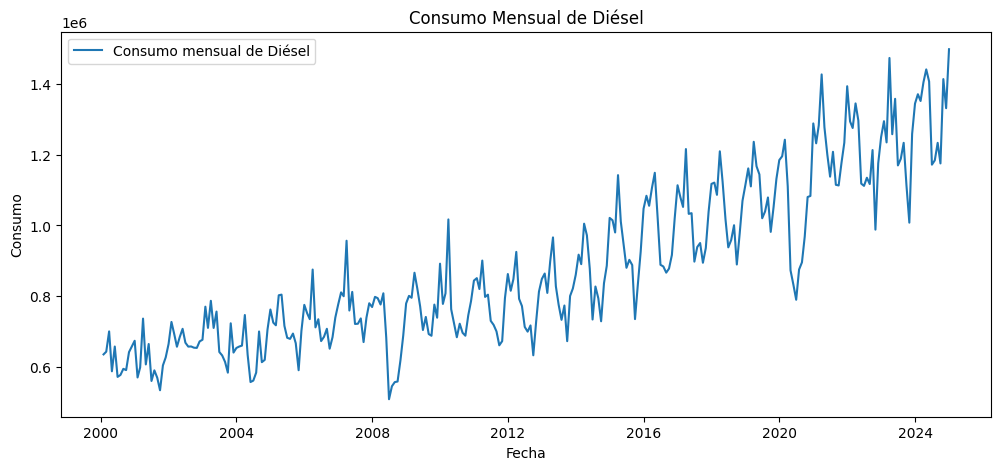

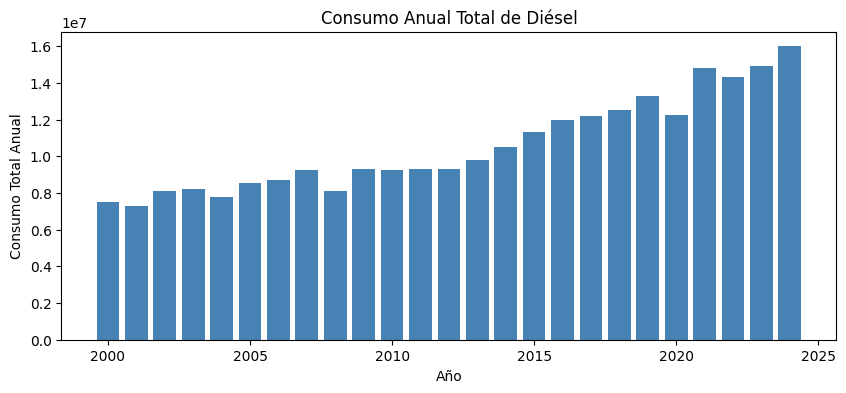

In [ ]:
import matplotlib.pyplot as plt

# Serie mensual (resample mensual)
df_diesel = df_cons.set_index('Fecha').resample('M').sum()

# Serie anual (resample anual)
df_diesel_anual = df_diesel.resample('A').sum()

# Gráfico mensual
plt.figure(figsize=(12,5))
plt.plot(df_diesel.index, df_diesel['Diesel'], label='Consumo mensual de Diésel')
plt.title('Consumo Mensual de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

# Gráfico anual
plt.figure(figsize=(10,4))
plt.bar(df_diesel_anual.index.year,
         df_diesel_anual['Diesel'], color='steelblue')
plt.title('Consumo Anual Total de Diésel')
plt.xlabel('Año')
plt.ylabel('Consumo Total Anual')
plt.show()

### Observaciones Iniciales

- La serie presenta una **tendencia creciente** clara a lo largo de los años, especialmente después del año 2015.
- Se observan **picos de consumo** recurrentes en ciertos meses del año, indicando una posible **estacionalidad anual**.
- Durante los años 2020 y 2021 (pandemia), el consumo muestra una ligera caída, seguida de una recuperación acelerada.
- El gráfico anual evidencia un **crecimiento sostenido en el consumo total anual**, con valores máximos alcanzados en los últimos años.
- La variabilidad mensual es significativa, indicando la existencia de factores cíclicos o estacionales adicionales.
- Se evidencia un posible **aumento en la variabilidad** del consumo en los años más recientes (mayor dispersión en los picos y valles).

En resumen, el consumo de diésel muestra comportamiento **tendencial, estacional y no estacionario**, lo que justifica el uso de técnicas de series de tiempo para su análisis y predicción.

## Serie Univariante - Definición

- Variable: Consumo mensual de Diésel (`Diesel`).
- Inicio: 2000-01.
- Fin: 2025-07 (último dato disponible).
- Frecuencia: Mensual (resampleo 'M').

Esta serie representa el comportamiento histórico del consumo nacional de diésel.

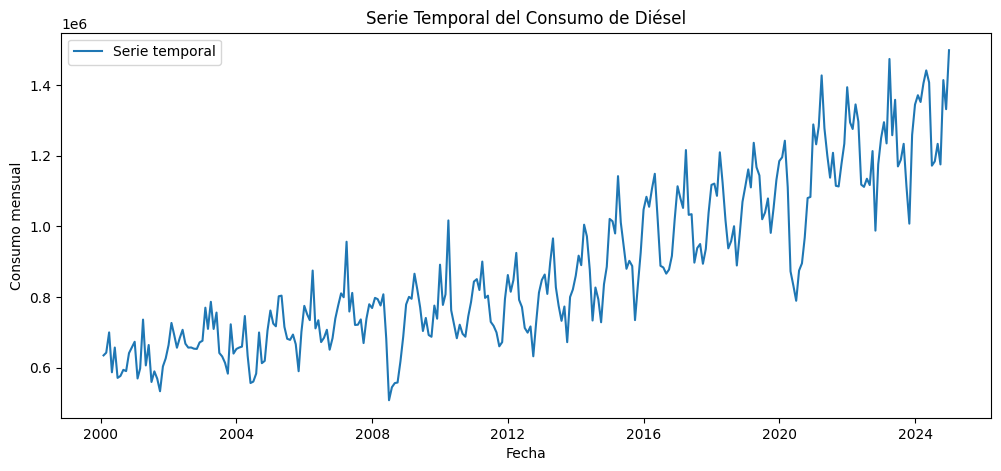

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df_diesel.index, df_diesel['Diesel'], label='Serie temporal')
plt.title('Serie Temporal del Consumo de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Consumo mensual')
plt.legend()
plt.show()

## Descomposición de la Serie Temporal

Analizamos los componentes: tendencia, estacionalidad y residuo.

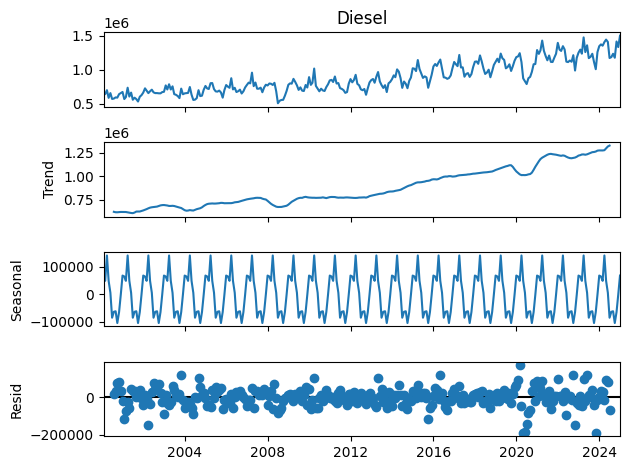

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_diesel['Diesel'], model='additive', period=12)
resultado.plot()
plt.show()

### Análisis de la Descomposición

- **Serie original**: Se observa una serie creciente con variabilidad significativa en el corto plazo.

- **Tendencia**: Existe una tendencia claramente creciente desde 2000 hasta 2024, aunque con cierta estabilización temporal en el periodo cercano al 2020, posiblemente por efectos de la pandemia.

- **Estacionalidad**: El patrón estacional es muy evidente:
  - El ciclo se repite cada 12 meses (confirmando estacionalidad anual).
  - En ciertos meses del año el consumo es sistemáticamente mayor o menor.

- **Componente residual**:
  - El componente residual parece relativamente estable.
  - Se observan algunos valores atípicos (outliers) en años recientes (posiblemente durante 2020 y 2021).

### Conclusión

A partir del análisis de la descomposición podemos concluir que:

- La serie **no es estacionaria en media**, debido a la tendencia creciente.
- La serie presenta **estacionalidad marcada**.
- El modelo que se use deberá considerar:
  - Eliminación o diferenciación para la tendencia.
  - Captura del componente estacional.